# Plasma Frequency Tutorial with PlasmaTorch

## Introduction
In this tutorial, we will demonstrate how to simulate **plasma oscillations** using **PlasmaTorch**. We set up a simple 2D simulation with electrons and ions, include an initial velocity perturbation, and observe the plasma oscillations.

### Physical Background
Plasma oscillations occur when electrons collectively oscillate against a background of fixed (or heavier) ions. The characteristic oscillation frequency of electrons in an unmagnetized plasma is known as the **electron plasma frequency**, given by:

$$ \omega_{pe} = \sqrt{\frac{n_e e^2}{\varepsilon_0 m_e}} $$

where:
- \(n_e\) is the electron number density,
- \(e\) is the elementary charge,
- \(m_e\) is the electron mass,
- \(epsilon_0\) is the vacuum permittivity.

In this example, we place ions (positively charged) and electrons (negatively charged) in a box with reflecting boundaries and give the electrons a small velocity perturbation. As they oscillate around their equilibrium position, we expect to see oscillations at (or near) the plasma frequency.

## Cell 1: Imports, Device Setup, and Preparations
Here we:
- Enable automatic reloading of modules with `%autoreload`.
- Import all necessary Python libraries and modules from **PlasmaTorch**.
- Append the local paths for importing `plasmatorch`.
- Detect if a GPU is available and set it as the computation device.
- Fix the random seed for reproducibility.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.autograd.profiler as profiler
from scipy.constants import *

import sys
sys.path.append("../")
sys.path.append("../plasmatorch")

from plasmatorch.simulator import *
from plasmatorch.utils import *
from plasmatorch.deposition import *
from plasmatorch.fields import *
from plasmatorch.helper import *

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(2304)

## Cell 2: Defining the Simulation Domain and PlasmaTorch Setup
In this cell, we:
- Define the 2D simulation domain size (\(L_x\) and \(L_y\)) and the number of grid points (\(N_x\), \(N_y\)).
- Specify the total simulation time and time step.
- Choose the computational backend (CPU or GPU). Here, we set it to `'cpu'` for simplicity, but you may use `'cuda'` if available.
- Create an instance of **PlasmaTorch** using the given parameters.
- Switch the Poisson solver to `"gauss_seidel"` for solving the electric potential.

In [2]:
# Parameters
Lx, Ly = 1.0, 1.0
Nx, Ny = 64, 64
simulation_time = 3e-7
dt = 1e-9
backend = "cpu"
simulation_name = "Test_2"

sim = PlasmaTorch(
    simulation_name= simulation_name,
    Lx=Lx,
    Ly=Ly,
    Nx=Nx,
    Ny=Ny,
    simulation_time=simulation_time,
    dt=dt,
    boundaries_type="reflecting",
    save_frequency=2,
    backend= backend
)

sim.poisson_method = "gauss_seidel"

## Cell 3: Adding Species (Ions and Electrons)
Here, we:
- Create ions (positively charged) with a chosen mass ratio (e.g., 1836 to represent a proton–electron mass ratio if desired) and zero initial temperature.
- Create electrons (negatively charged) with mass 1 (electron mass is our unit) and again zero initial temperature.
- Randomly distribute both species in the simulation domain.

These two populations form our basic plasma. We keep them cold (temperature = 0) so that the only motion they will have initially (for electrons) is the small velocity perturbation we apply next.

In [3]:
# Create ions (positive charge)
num_ioni = 10000
sim.create_new_specie(
    name="ioni",
    num_particles=num_ioni,
    temperature=0.0,
    distribution="zero",  # zero initial velocity
    mass=1836.0,          # ratio to electron mass
    charge=1.0,
    disposition="random"
)

# Create electrons (negative charge)
num_elettroni = 10000
sim.create_new_specie(
    name="elettroni",
    num_particles=num_elettroni,
    temperature=0.0,
    distribution="zero",
    mass=1.0,
    charge=-1.0,
    disposition="random"
)

## Cell 4: Introducing a Velocity Perturbation
To excite plasma oscillations, we give electrons a small sinusoidal velocity perturbation in the \(x\)-direction:

$$ v_{x,\mathrm{electron}} \propto \sin\left( 2\pi x / L_x \right) $$

This will trigger collective electron oscillations against the ionic background. We only modify the velocity of the electrons (`is_electron`) while leaving the ions at rest.

In [4]:
# Add a small velocity perturbation to electrons
vx_perturb = 0.01  # amplitude of the perturbation
positions = sim.particles_position
# Select only electrons
is_electron = (sim.particles_specie == sim.name_register.tolist().index("elettroni"))
sim.particles_velocity[is_electron, 0] += vx_perturb * torch.sin(
    2.0 * np.pi * positions[is_electron, 0] / Lx
)

## Cell 5: Running the Simulation
We now call the **`simulate()`** method of **PlasmaTorch**, which advances the system in time, updates positions and velocities of the particles, and solves for the fields.

In [5]:
# Run the simulation
sim.simulate()

  0%|          | 0/299 [00:00<?, ? step/s]c:\Users\Marco\Desktop\PlasmaTorch\examples\../plasmatorch\fields.py:245: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Cross.cpp:66.)
  v_prime = v_minus + torch.cross(v_minus, t)
100%|██████████| 299/299 [05:54<00:00,  1.19s/ step]

Energia cinetica: []
Energia potenziale: []
Energia totale: []


## Cell 6: Loading the Simulation Results
If we saved our simulation data to disk, we can reload it as a dictionary for post-processing or animation. Here, we just demonstrate how to call the **`load_simulation()`** function by passing the name of the simulation and the device (`cpu` or `cuda`).

In [9]:
simulation = load_simulation(simulation_name, device= backend)

[INFO] Loaded datasets from Test_2: ['charge_register', 'fields_chronology', 'fixed_potential_mask', 'fixed_potential_value', 'grid_chronology', 'kinetic_energy_chronology', 'mass_register', 'mechanic_energy_chronology', 'particles_active_chronology', 'particles_position_chronology', 'particles_specie_chronology', 'particles_velocity_chronology', 'potential_energy_chronology', 'solid_mask', 'solid_type']


## Cell 7: Interactive Visualization
By enabling the `%matplotlib widget` backend, we can explore time steps interactively using a slider. The function `dynamic_slider(simulation, Lx, Ly)` (provided within **PlasmaTorch** utilities) opens a dynamic plot that allows you to view how the particles move across different time steps.

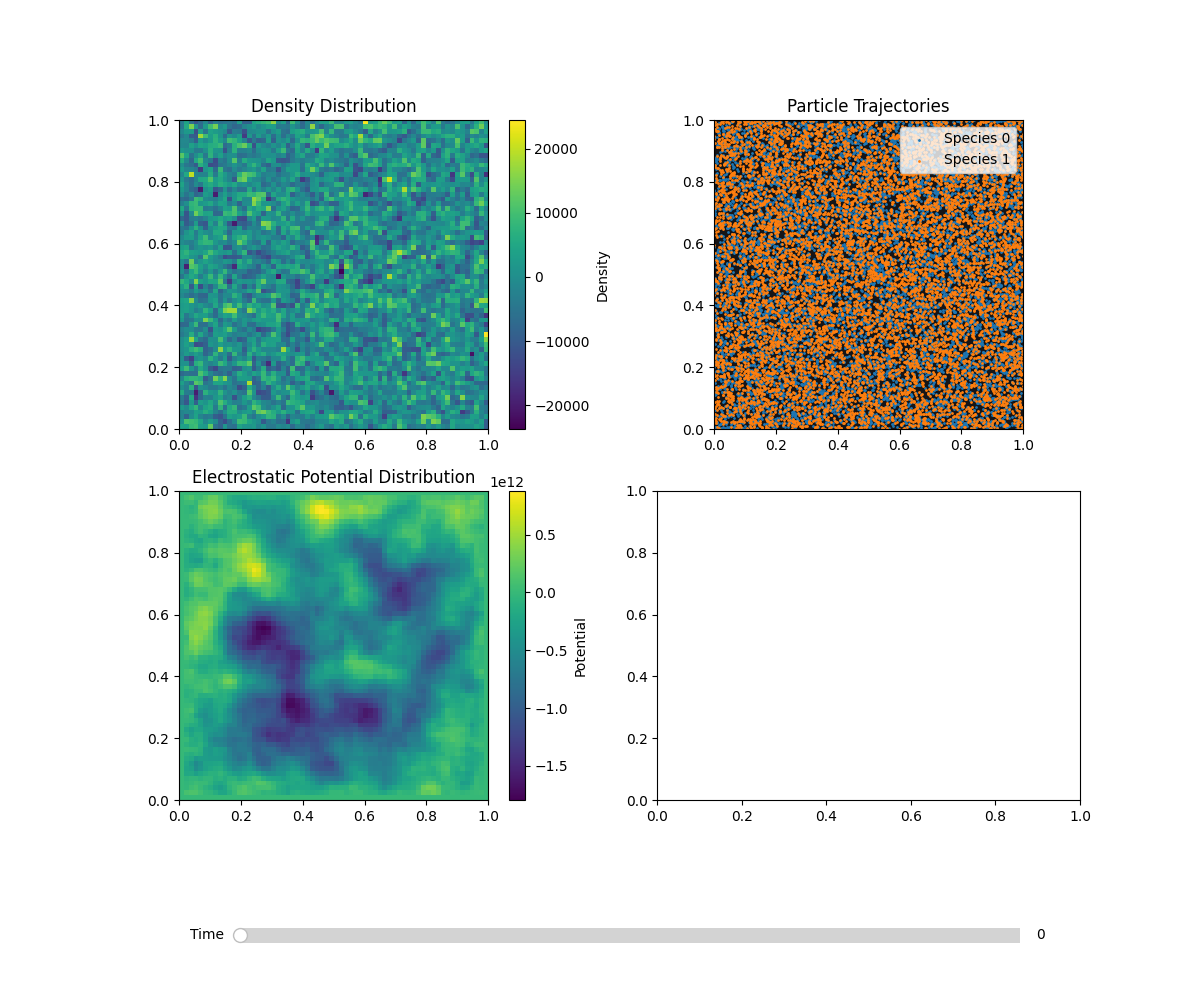

In [10]:
%matplotlib widget

dynamic_slider(simulation, Lx, Ly)

## Cell 8: Plotting the Energy Evolution
Finally, we can plot the evolution of kinetic, potential, and total (mechanical) energy over time. In a well-behaved simulation, total energy should remain nearly constant, while we observe oscillations between kinetic and potential energy components.

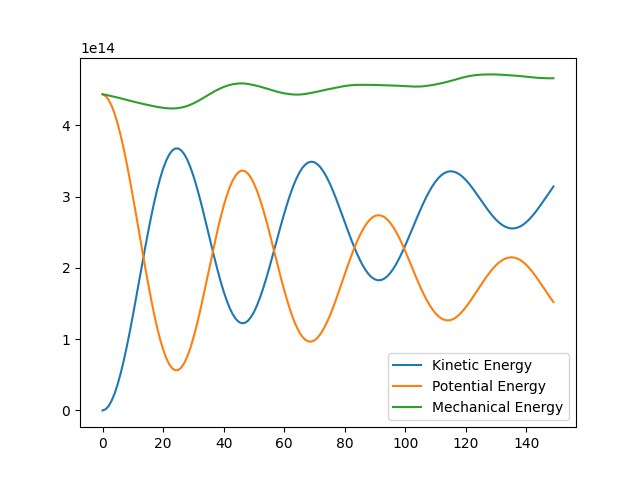

In [11]:
plt.close()
plt.figure()
plt.plot(simulation['kinetic_energy_chronology'], label="Kinetic Energy")
plt.plot(simulation['potential_energy_chronology'], label="Potential Energy")
plt.plot(simulation['mechanic_energy_chronology'], label="Mechanical Energy")
plt.legend()
plt.show()

## Conclusion
In this tutorial, we demonstrated how to set up a basic plasma simulation in **PlasmaTorch** with electrons and ions, introduce a small velocity perturbation, and observe plasma oscillations. The oscillation frequency should match (or be close to) the theoretical plasma frequency \(\omega_{pe}\). This example serves as a starting point for more advanced simulations, including finite temperatures, different boundary conditions, or additional physics such as collisions and external fields.